In [1]:
import pandas as pd
# from sklearn.ensemble
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def readFile(filename):
    f = pd.read_csv(f'./_data/{filename}.csv')
    return f

def ACCURACY(true, pred):
    score = np.mean(true==pred)
    return score

def z_oForType(data,columnName):
    columns = set(data[columnName].values)
    colNames = {}
    for key, value in enumerate(columns):
        colNames[value] = key
    data[columnName] = data[columnName].map(lambda x: colNames[x])
    #data[columnName] = data[columnName].replace(colNames) 로 해도 된답니다.
    return data

In [3]:
train_data = readFile('train')      #[3231 rows x 14 columns]
train_data = z_oForType(train_data, 'type')

#print(train_data)
test_data = readFile('test')
test_data = z_oForType(test_data, 'type')

# 결측치 확인
print(f"train_data의 결측치:")
print(f"{train_data.isna().sum()}")
print("-"*30)
print(f"test_data 결측치:")
print(f"{test_data.isna().sum()}")
print("-"*30)

train_data의 결측치:
id                      0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
quality                 0
dtype: int64
------------------------------
test_data 결측치:
id                      0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
dtype: int64
------------------------------


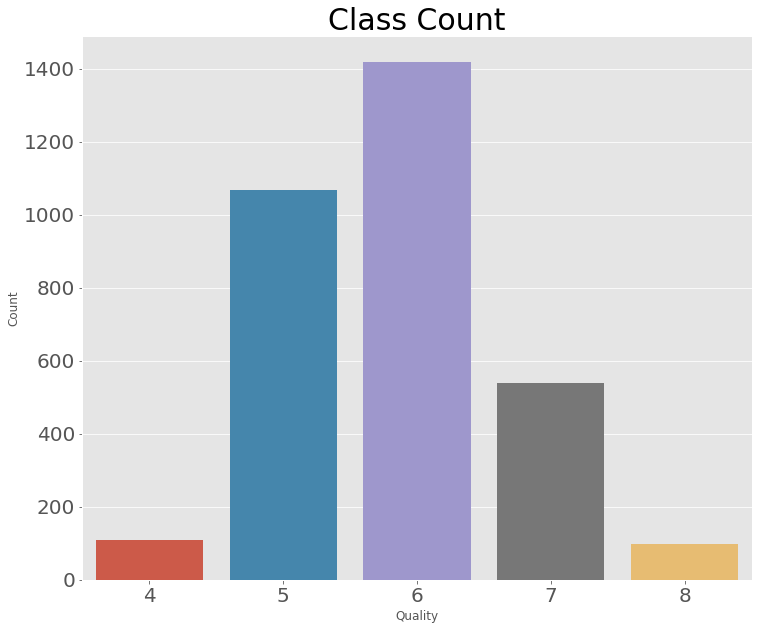

In [4]:
#     특정 클래스 데이터가 치우쳐 있는지 확인하고 데이터를 추가 등의 계획 수립
#     클래스 분포 확인. 4~8등의 와인이 있고 대부분의 데이터가 5~6에 치우쳐 있음
counted_values = train_data['quality'].value_counts()
plt.style.use('ggplot')
plt.figure(figsize=(12, 10))
plt.title('Class Count', fontsize=30)
    
value_bar_ax = sns.barplot(x=counted_values.index, y=counted_values)
value_bar_ax.tick_params(labelsize=20)
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

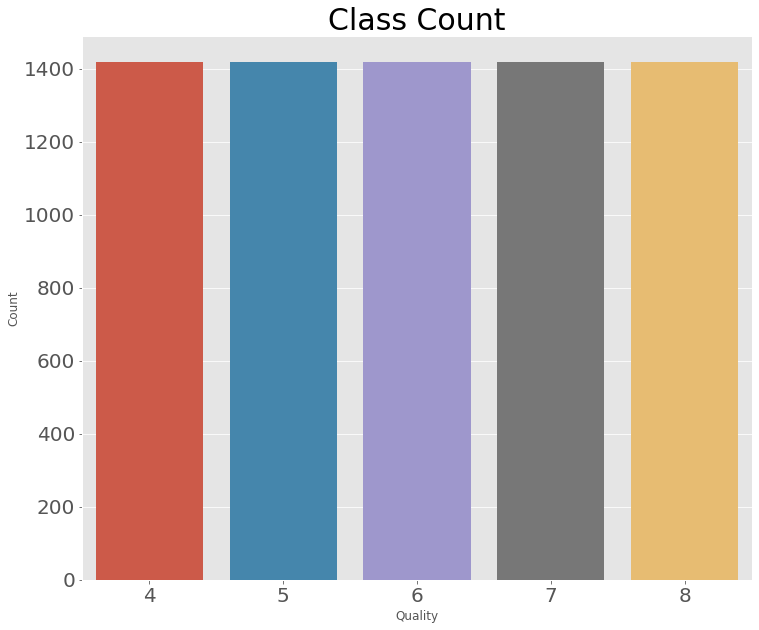

In [5]:
X_train = train_data.drop(columns=['id', 'quality'])
y_train = train_data['quality']

X_test = test_data.drop(columns=['id'])

# 데이터 불균형 해결을 위해 샘플링
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# 그래프로 추가된 데이터 확인
counted_values = y_res.value_counts()
plt.style.use('ggplot')
plt.figure(figsize=(12, 10))
plt.title('Class Count', fontsize=30)
    
value_bar_ax = sns.barplot(x=counted_values.index, y=counted_values)
value_bar_ax.tick_params(labelsize=20)
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

 1       alcohol       0.12719570694316537
 2       free sulfur dioxide       0.10659643297175803
 3       volatile acidity       0.10117309509265232
 4       total sulfur dioxide       0.09613823185747479
 5       density       0.09099818227038987
 6       chlorides       0.08547064295863459
 7       residual sugar       0.08159954317136373
 8       pH       0.0796105391671149
 9       sulphates       0.07749994239029032
10       citric acid       0.07629655475795434
11       fixed acidity       0.07281631571913406
12       type       0.004604812700067723


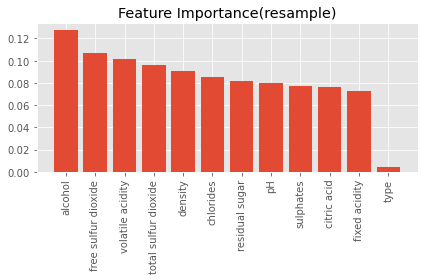

In [9]:
#리샘플링 한 데이터로 훈련
from sklearn.model_selection import train_test_split
X_train_resample,  X_test_resample, y_train_resample, y_test_resample = train_test_split(X_res, y_res, test_size=0.3, random_state=1)

from sklearn.ensemble import RandomForestClassifier
forest_resample = RandomForestClassifier(n_estimators=500, random_state=1, class_weight='balanced')
forest_resample.fit(X_train_resample, y_train_resample)
importances_resample = forest_resample.feature_importances_
indices_resample = np.argsort(importances_resample)[::-1]
feat_labels = X_train_resample.columns[:]

# 랜덤포레스트 중요한 특성 5개 출력
for f in range(X_train_resample.shape[1]):
    print(f"{f + 1:2d} {' '*5} {feat_labels[indices_resample[f]]} {' '*5} {importances_resample[indices_resample[f]]}")
plt.title('Feature Importance(resample)')
plt.bar(range(X_train_resample.shape[1]), importances_resample[indices_resample], align='center')
plt.xticks(range(X_train_resample.shape[1]), feat_labels[indices_resample], rotation=90)
plt.xlim([-1, X_train_resample.shape[1]])
plt.tight_layout()
plt.show()

In [14]:
# RFE를 사용하여 우선순위가 높은 특성 5개를 선택하여 훈련
from sklearn.feature_selection import RFE
rfe = RFE(forest_resample, n_features_to_select=5)
rfe.fit(X_train_resample, y_train_resample)
#print(rfe.ranking_)     # 선택한 특성의 우선순위 저장 --> 모델이 선택한 특성은 1로 나타냄
f_mask = rfe.support_
importances_resample = rfe.estimator_.feature_importances_
indices = np.argsort(importances_resample)[::-1]

for i in indices:
    print(f"{i+1:2d} {' '*5} {feat_labels[f_mask][i]} {' '*5} {importances_resample[i]}")
    
prediction = forest_resample.predict(X_test_resample)
score = ACCURACY(y_test_resample, prediction)
print(f'모델의 정확도: {score*100:.2f}%')

 5       alcohol       0.21955641097862588
 3       total sulfur dioxide       0.20417962924895824
 2       free sulfur dioxide       0.19582353804919067
 1       volatile acidity       0.19278710748351738
 4       density       0.18765331423970777
모델의 정확도: 80.77%


In [ ]:
#     prediction = forest_resample.predict(X_test)
#     print(prediction)
#     submission = pd.read_csv('./_data/sample_submission.csv')
#     submission['quality'] = prediction
#     submission.to_csv("./_data/output/submission(feature=5).csv", index=False)

In [15]:
rfe = RFE(forest_resample, n_features_to_select=3)
rfe.fit(X_train_resample, y_train_resample)
f_mask = rfe.support_
importances_resample = rfe.estimator_.feature_importances_
indices = np.argsort(importances_resample)[::-1]
    
for i in indices:
    print(f"{i+1:2d} {' '*5} {feat_labels[f_mask][i]} {' '*5} {importances_resample[i]}")
    
prediction = forest_resample.predict(X_test_resample)
score = ACCURACY(y_test_resample, prediction)
print(f'모델의 정확도: {score*100:.2f}%')

# prediction = forest_resample.predict(X_test)
# print(prediction)
# submission = pd.read_csv('./_data/sample_submission.csv')
# submission['quality'] = prediction
# submission.to_csv("./_data/output/submission(feature=3).csv", index=False)

 3       alcohol       0.3439408939135726
 2       total sulfur dioxide       0.34344252780171824
 1       free sulfur dioxide       0.3126165782847093
모델의 정확도: 80.77%


In [17]:
# train/test나누지 않고 다시 훈련
forest_ = RandomForestClassifier(n_estimators=500, random_state=1)
forest_.fit(X_res, y_res)
importances_ = forest_.feature_importances_
indices_ = np.argsort(importances_)[::-1]
feat_labels = X_train_resample.columns[:]
    
rfe = RFE(forest_, n_features_to_select=5)
rfe.fit(X_res, y_res)
f_mask = rfe.support_
importances_ = rfe.estimator_.feature_importances_
indices = np.argsort(importances_)[::-1]
    
for i in indices:
    print(f"{i+1:2d} {' '*5} {feat_labels[f_mask][i]} {' '*5} {importances_[i]}")
    
prediction = forest_.predict(X_test)
submission = pd.read_csv('./_data/sample_submission.csv')
submission['quality'] = prediction
submission.to_csv("./_data/output/submission_all_data(RFE feature=5).csv", index=False)

 7       alcohol       0.16444957833264326
 5       total sulfur dioxide       0.1520982423090919
 4       free sulfur dioxide       0.1484666157691162
 1       volatile acidity       0.1480550971803166
 6       density       0.13526502775195753
 3       chlorides       0.12768560505690318
 2       residual sugar       0.12397983359997132


In [ ]:
# 선택한 특성 5==7 정확도 같음